<a href="https://colab.research.google.com/github/url-github/Data-Engineering/blob/main/3_Spotify_3_LOAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://pl.wikipedia.org/wiki/Mapowanie_obiektowo-relacyjne

In [ ]:
# https://python101.readthedocs.io/pl/latest/bazy/orm/

In [ ]:
# https://www.sqlalchemy.org/

Załadowanie odsłuchanych utworów ze Spotify do bazy `SQLite`

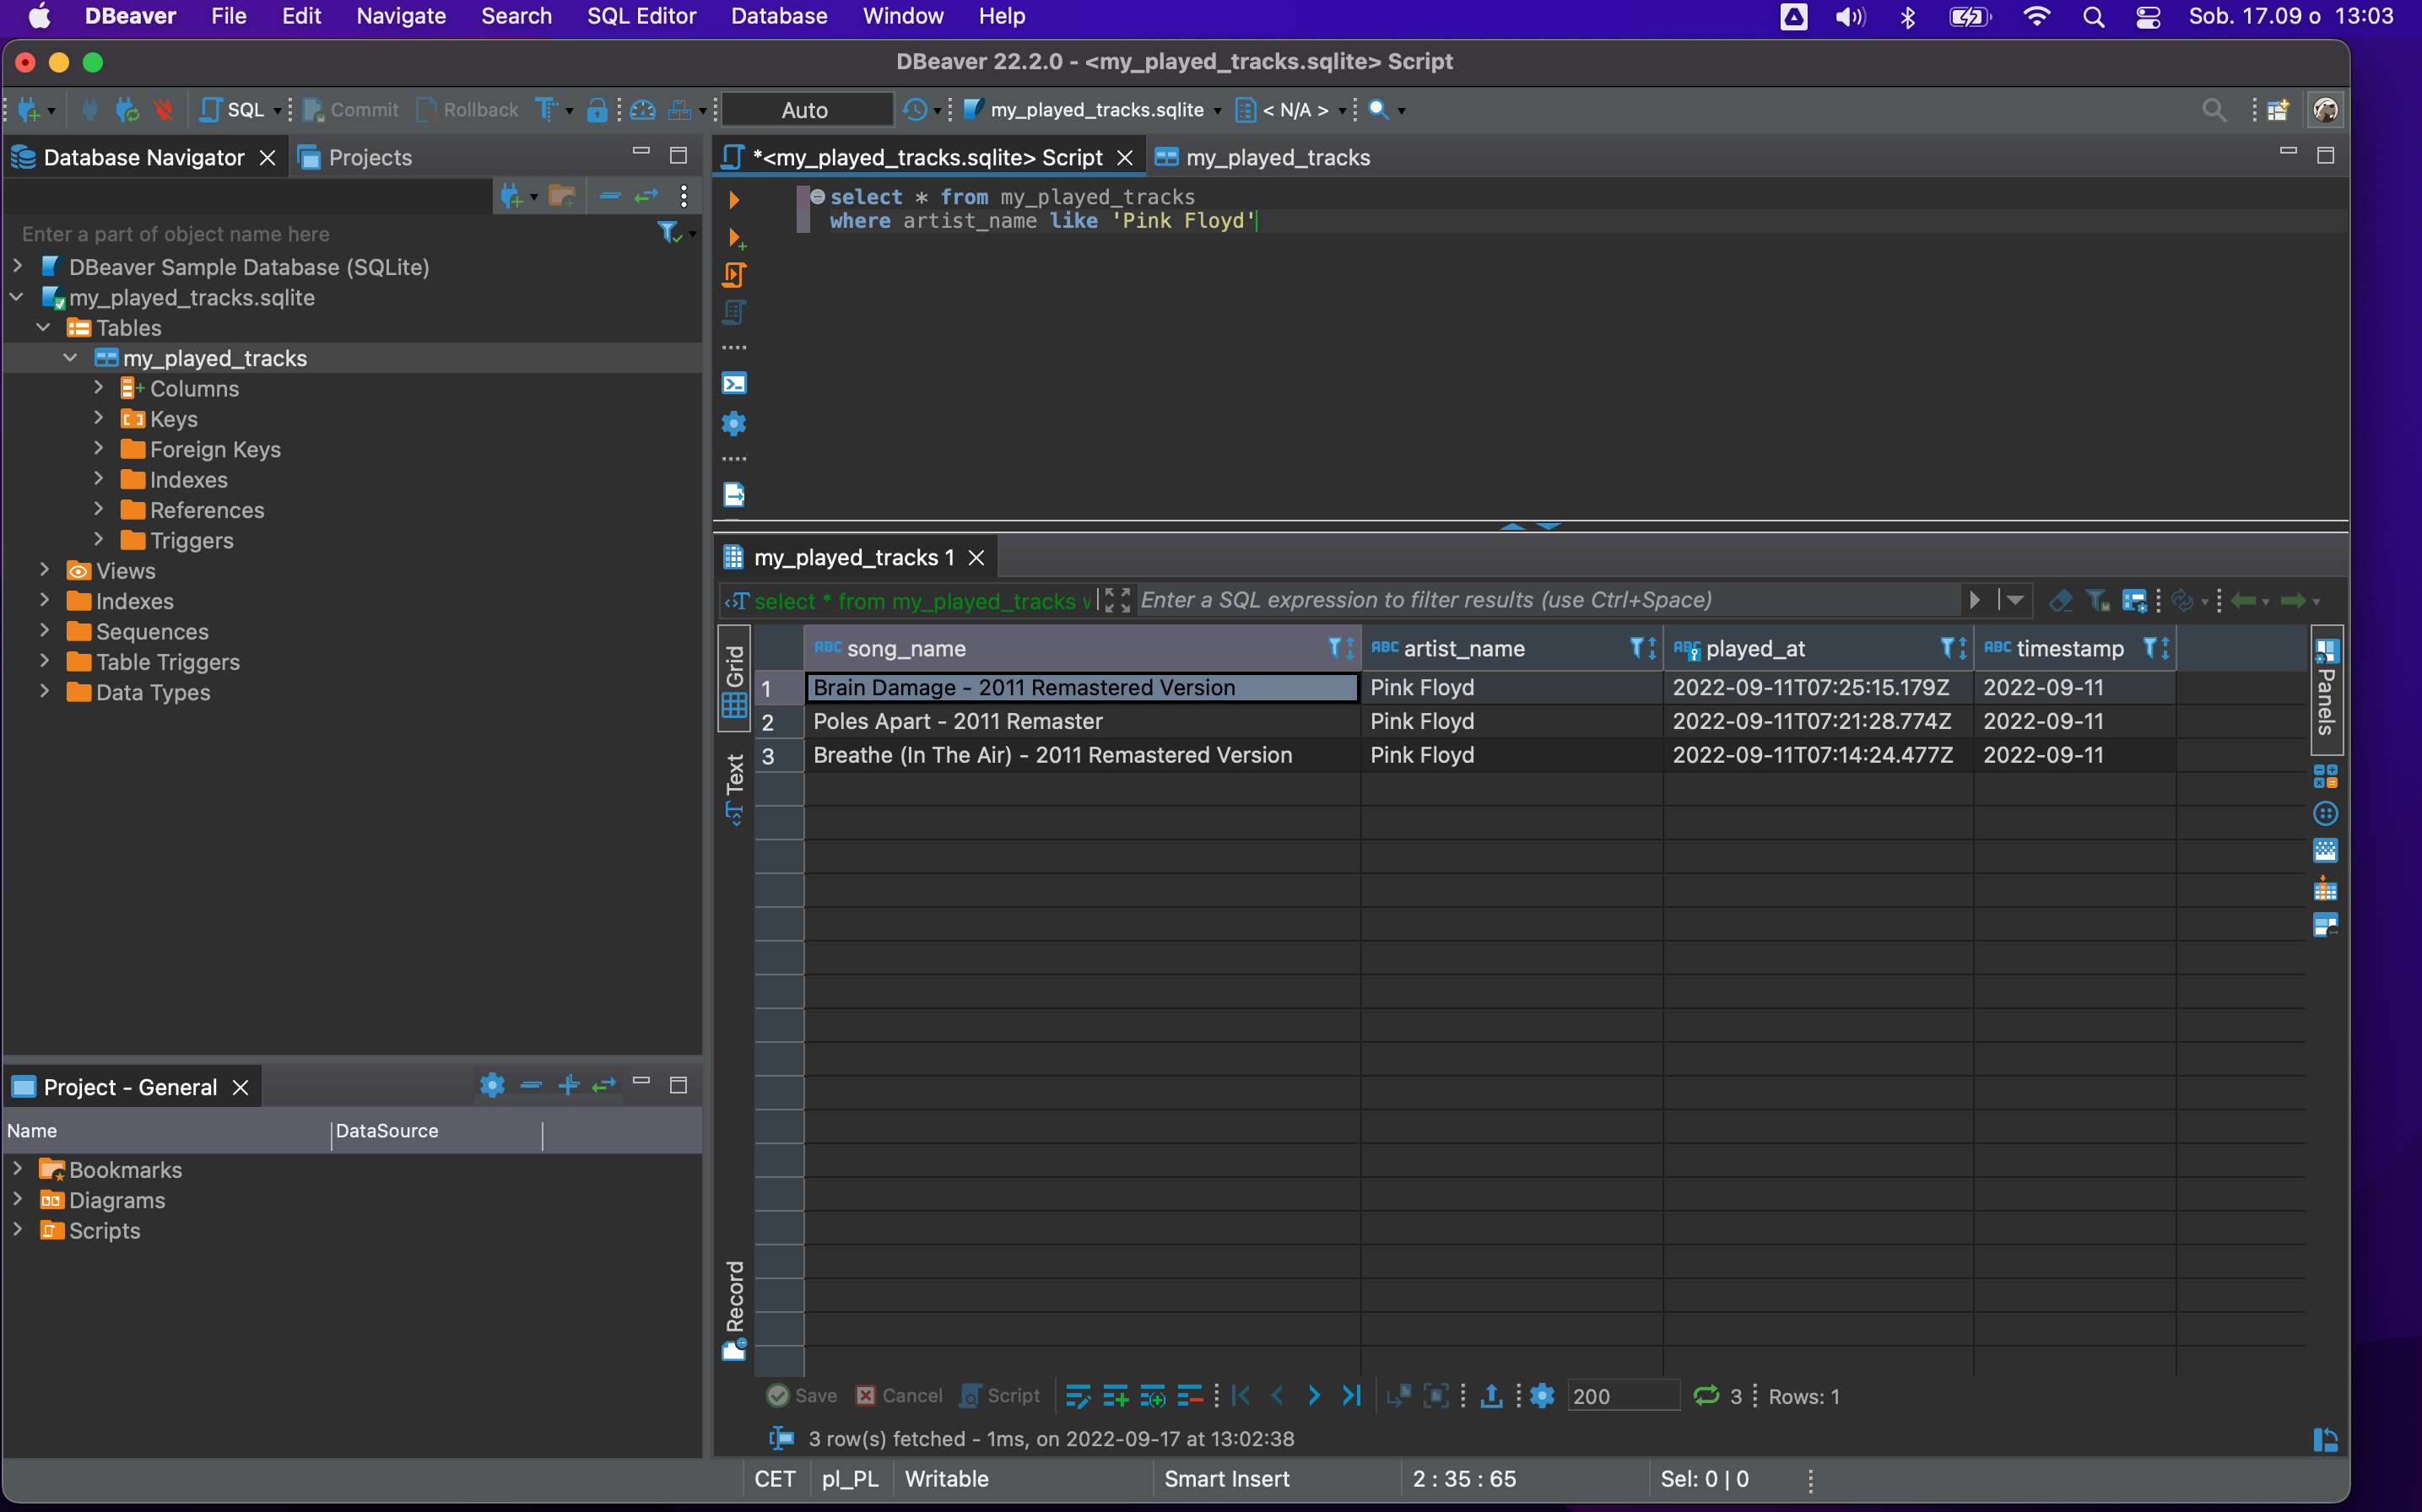

## IV wersja

In [ ]:
import sqlalchemy
import pandas as pd 
from sqlalchemy.orm import sessionmaker
import requests
import json
from datetime import datetime
import datetime
import sqlite3


DATABASE_LOCATION = "sqlite:///my_played_tracks.sqlite"
USER_ID = "31yahlyxg6b7b27ffx4qrguic5e4" # your Spotify username 
TOKEN = "BQCxOUil60254Dnhqq0OyaH-jkzZNN-fH7yzIUEjud_Wr7tuzAPoNg9ktBE6CY3czkO6lIETZI2spx-BbXbEDRQnmjwwHPBjdgXNCHRttRHkXviRAFyxV0yow9HfHK8-aGKew31bkUNOZbwxFATxrlX678BiO-VVtGTTR7CSNC8m9oxm8UlqnsnA_Jg4xTfl-6iqmojV" # your Spotify API token

# Generate your token here:  https://developer.spotify.com/console/get-recently-played/
# Note: You need a Spotify account (can be easily created for free)

def check_if_valid_data(df: pd.DataFrame) -> bool:
    # Sprawdź, czy dataframe jest pusty
    if df.empty:
        print("No songs downloaded. Finishing execution") # Nie pobrano żadnych utworów. 
        return False 

    # Sprawdzenie klucza podstawowego (Primary Key Check)
    if pd.Series(df['played_at']).is_unique:
        pass
    else:
        raise Exception("Primary Key check is violated") # Kontrola klucza podstawowego jest naruszona

    # Sprawdź, czy nie ma wartości null
    if df.isnull().values.any():
        raise Exception("Null values found") # Znaleziono null

    # Sprawdź, czy wszystkie znaczniki czasu pochodzą z wczorajszej daty
    yesterday = datetime.datetime.now() - datetime.timedelta(days=1)
    yesterday = yesterday.replace(hour=0, minute=0, second=0, microsecond=0)

    timestamps = df["timestamp"].tolist()
    for timestamp in timestamps:
        if datetime.datetime.strptime(timestamp, '%Y-%m-%d') != yesterday:
            raise Exception("Co najmniej jeden ze zwróconych utworów nie ma wczorajszego znacznika czasu")

    return True

if __name__ == "__main__":

    # Wyodrębnij część procesu ETL
 
    headers = {
        "Accept" : "application/json",
        "Content-Type" : "application/json",
        "Authorization" : f'Bearer {TOKEN}'
    }
    
    # Konwertuj czas na uniksowy znacznik czasu w milisekundach     
    today = datetime.datetime.now()
    yesterday = today - datetime.timedelta(days=1)
    yesterday_unix_timestamp = int(yesterday.timestamp()) * 1000

    # Pobierz wszystkie utwory, których słuchałeś „po wczoraj”, czyli w ciągu ostatnich 24 godzin    
    r = requests.get("https://api.spotify.com/v1/me/player/recently-played?after={time}".format(time=yesterday_unix_timestamp), headers = headers)

    data = r.json()

    song_names = []
    artist_names = []
    played_at_list = []
    timestamps = []

    # Wyodrębnianie tylko odpowiednich danych z obiektu json     
    for song in data["items"]:
        song_names.append(song["track"]["name"])
        artist_names.append(song["track"]["album"]["artists"][0]["name"])
        played_at_list.append(song["played_at"])
        timestamps.append(song["played_at"][0:10])

    # Przygotuj słownik, aby przekształcić go w data frame poniżej       
    song_dict = {
        "song_name" : song_names,
        "artist_name": artist_names,
        "played_at" : played_at_list,
        "timestamp" : timestamps
    }

    song_df = pd.DataFrame(song_dict, columns = ["song_name", "artist_name", "played_at", "timestamp"])

    # Validate
    if check_if_valid_data(song_df):
        print("Dane prawidłowe, przejdź do etapu ładowania (Load)")

    # Load

    engine = sqlalchemy.create_engine(DATABASE_LOCATION) # Tworzę engine wskazując lokalizację bazy
    conn = sqlite3.connect('my_played_tracks.sqlite') # Połączenie z nową bazą danych
    cursor = conn.cursor()

    # Tworzenie nowej tabeli
    sql_query = """
    CREATE TABLE IF NOT EXISTS my_played_tracks(
        song_name VARCHAR(200),
        artist_name VARCHAR(200),
        played_at VARCHAR(200),
        timestamp VARCHAR(200),
        CONSTRAINT primary_key_constraint PRIMARY KEY (played_at)
    )
    """

    cursor.execute(sql_query)
    print("Pomyślnie otwarto bazę danych")

    try:
        song_df.to_sql("my_played_tracks", engine, index=False, if_exists='append')
    except:
        print("Dane już istnieją w bazie danych")

    conn.close()
    print("Zamknij pomyślnie bazę danych")
    
    # Job scheduling 
    
    # For the scheduling in Airflow, refer to files in the dag folder 

Dane prawidłowe, przejdź do etapu ładowania (Load)
Pomyślnie otwarto bazę danych
Dane już istnieją w bazie danych
Zamknij pomyślnie bazę danych


## V wersja

Ostatnie 10 dni. Z funkcji `check_if_valid_data` usuwam kod odpowiedzialny za weryfikację - Sprawdź, czy wszystkie znaczniki czasu pochodzą z wczorajszej daty

In [ ]:
import sqlalchemy
import pandas as pd 
from sqlalchemy.orm import sessionmaker
import requests
import json
from datetime import datetime
import datetime
import sqlite3


DATABASE_LOCATION = "sqlite:///my_played_tracks.sqlite"
USER_ID = "31yahlyxg6b7b27ffx4qrguic5e4" # your Spotify username 
TOKEN = "BQCxOUil60254Dnhqq0OyaH-jkzZNN-fH7yzIUEjud_Wr7tuzAPoNg9ktBE6CY3czkO6lIETZI2spx-BbXbEDRQnmjwwHPBjdgXNCHRttRHkXviRAFyxV0yow9HfHK8-aGKew31bkUNOZbwxFATxrlX678BiO-VVtGTTR7CSNC8m9oxm8UlqnsnA_Jg4xTfl-6iqmojV" # your Spotify API token

# Generate your token here:  https://developer.spotify.com/console/get-recently-played/
# Note: You need a Spotify account (can be easily created for free)

def check_if_valid_data(df: pd.DataFrame) -> bool:
    # Sprawdź, czy dataframe jest pusty
    if df.empty:
        print("No songs downloaded. Finishing execution") # Nie pobrano żadnych utworów. 
        return False 

    # Sprawdzenie klucza podstawowego (Primary Key Check)
    if pd.Series(df['played_at']).is_unique:
        pass
    else:
        raise Exception("Primary Key check is violated") # Kontrola klucza podstawowego jest naruszona

    # Sprawdź, czy nie ma wartości null
    if df.isnull().values.any():
        raise Exception("Null values found") # Znaleziono null

    return True

if __name__ == "__main__":

    # Wyodrębnij część procesu ETL
 
    headers = {
        "Accept" : "application/json",
        "Content-Type" : "application/json",
        "Authorization" : f'Bearer {TOKEN}'
    }
    
    # Konwertuj czas na uniksowy znacznik czasu w milisekundach     
    today = datetime.datetime.now()
    yesterday = today - datetime.timedelta(days=10)
    yesterday_unix_timestamp = int(yesterday.timestamp()) * 1000

    # Pobierz wszystkie utwory, których słuchałeś „po wczoraj”, czyli w ciągu ostatnich 24 godzin    
    r = requests.get("https://api.spotify.com/v1/me/player/recently-played?after={time}".format(time=yesterday_unix_timestamp), headers = headers)

    data = r.json()

    song_names = []
    artist_names = []
    played_at_list = []
    timestamps = []

    # Wyodrębnianie tylko odpowiednich danych z obiektu json     
    for song in data["items"]:
        song_names.append(song["track"]["name"])
        artist_names.append(song["track"]["album"]["artists"][0]["name"])
        played_at_list.append(song["played_at"])
        timestamps.append(song["played_at"][0:10])

    # Przygotuj słownik, aby przekształcić go w data frame poniżej       
    song_dict = {
        "song_name" : song_names,
        "artist_name": artist_names,
        "played_at" : played_at_list,
        "timestamp" : timestamps
    }

    song_df = pd.DataFrame(song_dict, columns = ["song_name", "artist_name", "played_at", "timestamp"])

    # Validate
    if check_if_valid_data(song_df):
        print("Dane prawidłowe, przejdź do etapu ładowania (Load)")

    # Load

    engine = sqlalchemy.create_engine(DATABASE_LOCATION) # Tworzę engine wskazując lokalizację bazy
    conn = sqlite3.connect('my_played_tracks.sqlite') # Połączenie z nową bazą danych
    cursor = conn.cursor()

    # Tworzenie nowej tabeli
    sql_query = """
    CREATE TABLE IF NOT EXISTS my_played_tracks(
        song_name VARCHAR(200),
        artist_name VARCHAR(200),
        played_at VARCHAR(200),
        timestamp VARCHAR(200),
        CONSTRAINT primary_key_constraint PRIMARY KEY (played_at)
    )
    """

    cursor.execute(sql_query)
    print("Pomyślnie otwarto bazę danych")

    try:
        song_df.to_sql("my_played_tracks", engine, index=False, if_exists='append')
    except:
        print("Dane już istnieją w bazie danych")

    conn.close()
    print("Zamknij pomyślnie bazę danych")
    
    # Job scheduling 
    
    # For the scheduling in Airflow, refer to files in the dag folder 

Dane prawidłowe, przejdź do etapu ładowania (Load)
Pomyślnie otwarto bazę danych
Dane już istnieją w bazie danych
Zamknij pomyślnie bazę danych
